# Combined results

Combines results from both test scenes.

In [1]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%load_ext autoreload
%autoreload 2
from mcrf.utils.setup_notebook import *
from netCDF4 import Dataset
from mcrf.liras import liras_path
from mcrf.liras.model_data import ModelDataProvider
from mcrf.liras.results import get_results, get_reference_data

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras
Loading ARTS API from: /home/simonpf/build/arts_fast/src/libarts_api.so


In [2]:
import os
from typhon.arts.xml import load
from mcrf.liras import liras_path
gci_d = load(os.path.join(liras_path, "data",
                     "scattering", "GemCloudIce.xml"))
gs_d = load(os.path.join(liras_path, "data",
                     "scattering", "GemSnow.xml"))
gci_m = load(os.path.join(liras_path, "data",
                     "scattering", "GemCloudIce.meta.xml"))
gs_m = load(os.path.join(liras_path, "data",
                     "scattering", "GemSnow.meta.xml"))

In [3]:
gci_d[0].abs_vec_data.shape

(34, 4, 1, 1, 1)

In [4]:
gci_ext = np.stack([d.ext_mat_data[:, 0, 0, 0, 0] for d in gci_d])
gci_abs = np.stack([d.abs_vec_data[:, 0, 0, 0, 0] for d in gci_d])
gs_ext = np.stack([d.ext_mat_data[:, 0, 0, 0, 0] for d in gs_d])
gs_abs = np.stack([d.abs_vec_data[:, 0, 0, 0, 0] for d in gs_d])
gci_ssa = (gci_ext - gci_abs) / gci_ext
gs_ssa = (gs_ext - gs_abs) / gs_ext

x_gci = np.array([d.diameter_volume_equ for d in gci_m])
x_gs = np.array([d.diameter_volume_equ for d in gs_m])

In [5]:
variables = ["diagnostics", "ice_n0", "ice_dm"]
results_a = get_results(variables = variables, scene = "a", config = "", type_suffix = "")
results_b = get_results(variables = variables, scene = "b", config = "", type_suffix = "")
results_a_po = get_results(variables = variables, scene = "a", config = "", type_suffix = "po")
results_b_po = get_results(variables = variables, scene = "b", config = "", type_suffix = "po")
results_a_ro = get_results(variables = variables, scene = "a", config = "", type_suffix = "ro")
results_b_ro = get_results(variables = variables, scene = "b", config = "", type_suffix = "ro")
_ = results_a.pop("GemGraupel_None")
_ = results_b.pop("GemGraupel_None")

In [6]:
reference_a = get_reference_data(scene = "a", i_start = 2800, i_end = 3600)
reference_b = get_reference_data(scene = "b", i_start = 2200, i_end = 3000)

/home/simonpf/src/parts/parts/scattering/psd/my05.py:207: RuntimeWarning: divide by zero encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:207: RuntimeWarning: invalid value encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:279: RuntimeWarning: divide by zero encountered in power
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:279: RuntimeWarning: invalid value encountered in multiply
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/d14.py:412: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simonpf/src/parts/parts/scattering/psd/d14.py:414: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4


In [7]:
def get_ssa_gci(f):
    data = gci_d
    ssa = np.zeros(len(data))
    for i in range(ssa.size):
        f_grid = data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

def get_ssa_gs(f):
    data = gs_d
    ssa = np.zeros(len(data))
    for i in range(ssa.size):
        f_grid = data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

def get_ssa(h, f):
    ssa = np.zeros(len(h.data))
    for i in range(ssa.size):
        f_grid = h.data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, h.data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, h.data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

## OEM cost

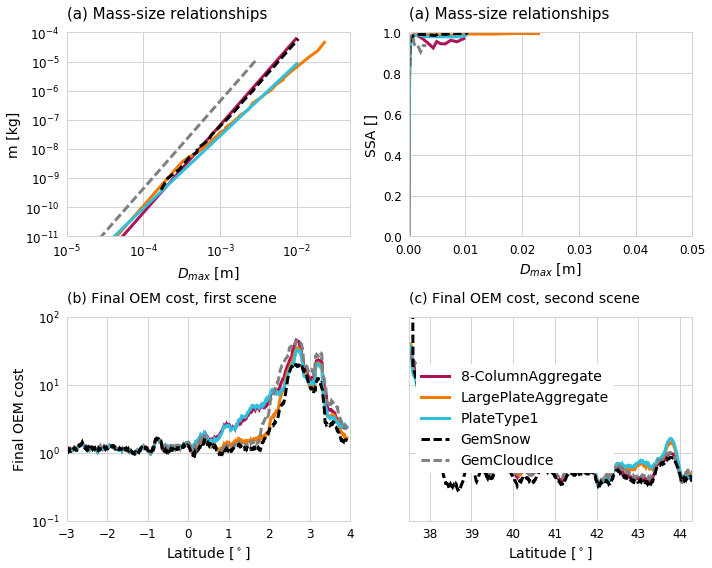

In [8]:
import sys
sys.path.append("/home/simonpf/src/ssdb")
import ssdb

eca = getattr(ssdb, "8-ColumnAggregate")
lpa = getattr(ssdb, "LargePlateAggregate")
pt1 = getattr(ssdb, "PlateType1")
gg  = getattr(ssdb, "GemGraupel")

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (10, 8))
gs = GridSpec(2, 2)

#
# Mass size relationship.
#

ax = plt.subplot(gs[0, 0])

handles = []
x = np.array([d.diameter_max for d in eca.meta_data])
y = np.array([d.mass for d in eca.meta_data])
handles += ax.plot(x, y, label = "8-ColumnAggregate", lw = 3)

x = np.array([d.diameter_max for d in lpa.meta_data])
y = np.array([d.mass for d in lpa.meta_data])
handles += ax.plot(x, y, label = "LargePlateAggregate", lw = 3)

x = np.array([d.diameter_max for d in pt1.meta_data])
y = np.array([d.mass for d in pt1.meta_data])
handles += ax.plot(x, y, label = "PlateType1", lw = 3)

x = np.array([d.diameter_max for d in gs_m])
y = np.array([d.mass for d in gs_m])
handles += ax.plot(x, y, label = "GemSnow", lw = 3, ls = "--", c = "k")

x = np.array([d.diameter_max for d in gci_m])
y = np.array([d.mass for d in gci_m])
handles += ax.plot(x, y, label = "GemCloudIce", lw = 3, ls = "--", c = "grey")

ax.set_xlim([1e-5, 5e-2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("m [kg]", fontsize = 14)
ax.set_xlabel("$D_{max}$ [m]", fontsize = 14)
ax.set_ylim([1e-11, 1e-4])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
ax.set_title("(a) Mass-size relationships", loc = "left", fontsize = 15)

#
# Single scattering albedo.
#

ax = plt.subplot(gs[0, 1])
f = 448e9
handles = []
x = np.array([d.diameter_max for d in eca.meta_data])
y = get_ssa(eca, f)
handles += ax.plot(x, y, label = "8-ColumnAggregate", lw = 3)

x = np.array([d.diameter_max for d in lpa.meta_data])
y = get_ssa(lpa, f)
handles += ax.plot(x, y, label = "LargePlateAggregate", lw = 3)

x = np.array([d.diameter_max for d in pt1.meta_data])
y = get_ssa(pt1, f)
handles += ax.plot(x, y, label = "PlateType1", lw = 3)

x = np.array([d.diameter_max for d in gs_m])
y = get_ssa_gs(f)
handles += ax.plot(x, y, label = "GemSnow", lw = 3, ls = "--", c = "k")

x = np.array([d.diameter_max for d in gci_m])
y = get_ssa_gci(f)
handles += ax.plot(x, y, label = "GemCloudIce", lw = 3, ls = "--", c = "grey")

ax.set_xlim([1e-5, 5e-2])
ax.set_ylabel("SSA []", fontsize = 14)
ax.set_xlabel("$D_{max}$ [m]", fontsize = 14)
ax.set_ylim([0, 1])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
ax.set_title("(a) Mass-size relationships", loc = "left", fontsize = 15)
    
    
#
# OEM cost
#

ax = plt.subplot(gs[1, 0])

hs = ["8-ColumnAggregate_None",
      "LargePlateAggregate_None",
      "PlateType1_None",
      "GemCloudIce_None",
      "GemSnow_None"]
cs = ["C0", "C1", "C2", "grey", "k"]
lss = (["-"] * 3 + ["--", "--"])
for h, c, ls in zip(hs, cs, lss):
    lats = reference_a["lat"]
    y = results_a[h]["diagnostics"][:, 3]
    y = np.convolve(y, np.ones(20) / 20.0, mode = "valid")
    x = np.convolve(lats, np.ones(20) / 20.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 3)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_ylabel("Final OEM cost", fontsize = 14)
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([-3, 4])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(b) Final OEM cost, first scene", loc = "left", fontsize = 14)

#
# OEM cost
#

ax = plt.subplot(gs[1, 1])

hs = ["8-ColumnAggregate_None",
      "LargePlateAggregate_None",
      "PlateType1_None",
      "GemCloudIce_None",
      "GemSnow_None"]
cs = ["C0", "C1", "C2", "grey", "k"]
lss = (["-"] * 3 + ["--", "--"])
for h, c, ls in zip(hs, cs, lss):
    lats = reference_b["lat"]
    y = results_b[h]["diagnostics"][:, 3]
    y[y.mask] = 0.0
    y = np.convolve(y, np.ones(20) / 20.0, mode = "valid")
    x = np.convolve(lats, np.ones(20) / 20.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 3)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_yticklabels([])
ax.set_xlim([37.5, 44.3])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(c) Final OEM cost, second scene", loc = "left", fontsize = 14)


#
# Legend
#

#ax = plt.subplot(gs[0, 1])
#ax.set_axis_off()

labels = ["8-ColumnAggregate", "LargePlateAggregate", "PlateType1", "GemSnow", "GemCloudIce"]
ax.legend(loc = "center left", handles = handles, labels = labels, fontsize = 14)

plt.tight_layout()
fig.savefig("../../plots/costs.pdf", bbox_inches = "tight")

## S

In [103]:
from crac.liras.results import plot_results
def iwc(n0, dm):
    return np.pi * 917.0 * dm ** 4 * n0 / 4 ** 4

In [110]:
qs_a = {}
qs_a_ro = {}
qs_a_po = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference_a["iwc"].shape)
q_r = np.maximum(reference_a["iwc"] + reference_a["swc"] + reference_a["hwc"] + reference_a["gwc"], 1e-8)


hs = [k for k in results_a.keys() if "None" in k]
for h in hs:
    rs = results_a[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_a[h] = (q_r.ravel(), q.ravel())

    rs = results_a_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_a_ro[h] = (q_r.ravel(), q.ravel())
    
    rs = results_a_po[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_a_po[h] = (q_r.ravel(), q.ravel())

In [111]:
qs_b = {}
qs_b_ro = {}
qs_b_po = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference_b["iwc"].shape)
q_r = np.maximum(reference_b["iwc"] + reference_b["swc"] + reference_b["hwc"] + reference_b["gwc"], 1e-8)

for h in hs:
    rs = results_b[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b[h] = (q_r.ravel(), q.ravel())

    rs = results_b_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_ro[h] = (q_r.ravel(), q.ravel())
    
    rs = results_b_po[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_po[h] = (q_r.ravel(), q.ravel())

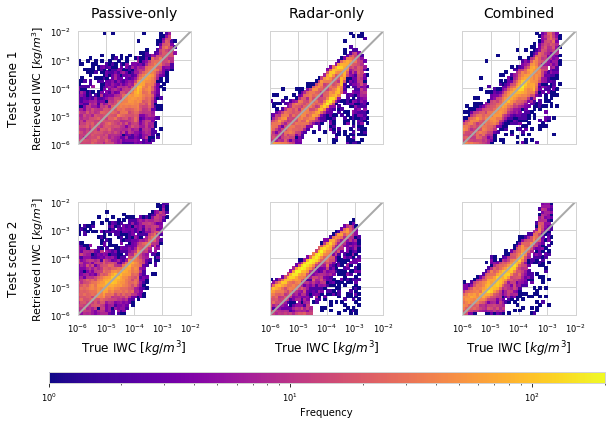

In [107]:
from matplotlib.colors   import LogNorm
from matplotlib.image    import imread
from matplotlib.cm import ScalarMappable

n  = 2
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 3, width_ratios = [1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = LogNorm(1, 200)
h = "LargePlateAggregate_None"

# Colorbar
sm = ScalarMappable(norm = norm, cmap = "plasma")
sm.set_array(np.linspace(0, 100, 101))
ax = plt.subplot(gs[-1, :])
plt.colorbar(sm, orientation = "horizontal", label = "Frequency", cax = ax)

#
# Habit types
#

# Scatter plot
for j, q in enumerate([qs_a_po, qs_a_ro, qs_a]):
    
    ax = plt.subplot(gs[0, j])
    x, y = q[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xticklabels([])
        
    titles = ["Passive-only", "Radar-only", "Combined"]
    ax.set_title(titles[j], fontsize = 14)
    
    if j == 0:
        col = "Test scene 1"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
            
# Scatter plot
for j, q in enumerate([qs_b_po, qs_b_ro, qs_b]):
    ax = plt.subplot(gs[1, j])
    x, y = q[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xlabel("True IWC [$kg / m^3$]", fontsize = 12)
    
    if j == 0:
        col = "Test scene 2"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
        
plt.tight_layout()

f.savefig("../../plots/results_hist.png", dpi = 500)

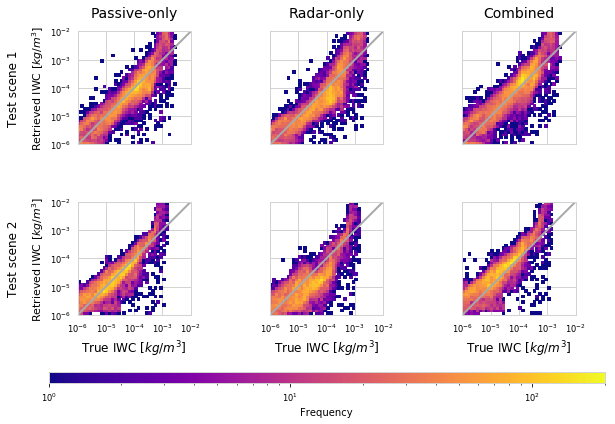

In [114]:
from matplotlib.colors   import LogNorm
from matplotlib.image    import imread
from matplotlib.cm import ScalarMappable

n  = 2
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 3, width_ratios = [1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = LogNorm(1, 200)
hs = ["LargePlateAggregate_None", "GemCloudIce_None", "GemSnow_None"]

# Colorbar
sm = ScalarMappable(norm = norm, cmap = "plasma")
sm.set_array(np.linspace(0, 100, 101))
ax = plt.subplot(gs[-1, :])
plt.colorbar(sm, orientation = "horizontal", label = "Frequency", cax = ax)

#
# Habit types
#

# Scatter plot
for j, h in enumerate(hs):
    
    ax = plt.subplot(gs[0, j])
    x, y = qs_a[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xticklabels([])
        
    titles = ["Passive-only", "Radar-only", "Combined"]
    ax.set_title(titles[j], fontsize = 14)
    
    if j == 0:
        col = "Test scene 1"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
            
# Scatter plot
for j, h in enumerate(hs):
    ax = plt.subplot(gs[1, j])
    x, y = qs_b[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xlabel("True IWC [$kg / m^3$]", fontsize = 12)
    
    if j == 0:
        col = "Test scene 2"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
        
plt.tight_layout()

f.savefig("../../plots/results_hist.png", dpi = 500)

## Box plots

### Data frames

In [218]:
import pandas as pd
data = {}
hs = [k for k in results_a.keys() if "None" in k]

retrieval_types = []
particle_names = []
quantities = []
scenes = []
errors = np.zeros(0)

for t, rs in zip(["Passive only", "Radar only", "Combined"],
                [qs_a_po, qs_a_ro, qs_a]):
    for h in hs:
        q_r, q = rs[h]
        name = h[:-5]
        
        es = 10.0 * np.log10(q / q_r)
        inds = q_r > 1e-7
        es = es[inds]
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWC"] * es.size
        scenes += ["A"] * es.size
        errors = np.concatenate([errors, es])
        
        # Column-integrated
        q_r = np.trapz(q_r.reshape(800, 58), x = z_a)
        q   = np.trapz(q.reshape(800, 58), x = z_a)
        es = 10.0 * np.log10(q / q_r)
        es = es.ravel()
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWP"] * es.size
        scenes += ["A"] * es.size
        errors = np.concatenate([errors, es])
        
        
for t, rs in zip(["Passive only", "Radar only", "Combined"],
                [qs_b_po, qs_b_ro, qs_b]):
    for h in hs:
        q_r, q = rs[h]
        name = h[:-5]
        
        es = 10.0 * np.log10(q / q_r)
        inds = q_r > 1e-7 #np.logical_or(q > 1e-6, q_r > 1e-6)
        es = es[inds]
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWC"] * es.size
        scenes += ["B"] * es.size
        errors = np.concatenate([errors, es])
        
        # Column-integrated
        q_r = np.trapz(q_r.reshape(800, 58), x = z_b)
        q   = np.trapz(q.reshape(800, 58), x = z_b)
        es = 10.0 * np.log10(q / q_r)
        es = es.ravel()
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWP"] * es.size
        scenes += ["B"] * es.size
        errors = np.concatenate([errors, es])
        
data = pd.DataFrame({"Retrieval type" : retrieval_types,
                    "Particle name" : particle_names,
                    "Quantity" : quantities,
                    "Scene" : scenes,
                    "Error" : errors})

In [219]:
import seaborn as sns
sns.reset_defaults()

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


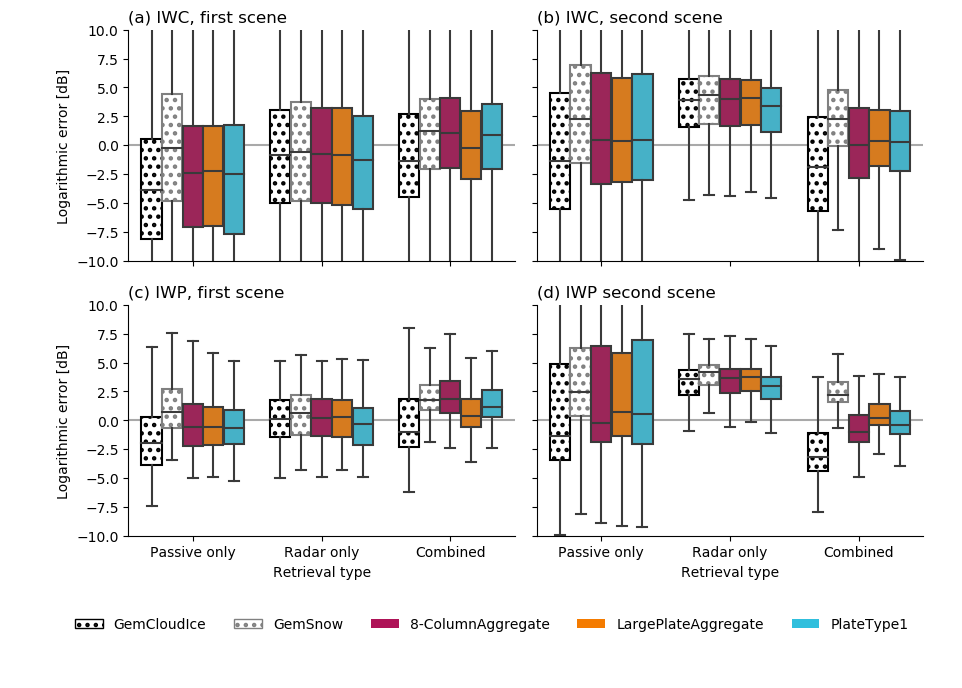

In [316]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
colors = {"GemCloudIce" : "white",
          "GemSnow" : "white",
          "8-ColumnAggregate" : '#ae1357',
          "LargePlateAggregate" : '#f47b00',
          "PlateType1" : '#30bfdd'}

order = ["GemCloudIce", "GemSnow", "8-ColumnAggregate", "LargePlateAggregate", "PlateType1"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data, row = "Quantity", kind = "box", showfliers = False,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False)

titles = [["(a) IWC, first scene", "(b) IWC, second scene"],
          ["(c) IWP, first scene", "(d) IWP second scene"]]
for i in range(2):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k % 5) == 0:
                artist.set_hatch(hatch)
                artist.set_edgecolor("k")
            if (k % 5) == 1:
                artist.set_hatch(hatch)
                artist.set_edgecolor("grey")
                
        if j == 0:
            ax.set_ylabel("Logarithmic error [dB]")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
            
#legend
handles = [patches.Patch(facecolor = colors["GemCloudIce"], edgecolor = "k", hatch = hatch, label = "GemCloudIce"),
           patches.Patch(facecolor = colors["GemSnow"], edgecolor = "grey", hatch = hatch, label = "GemSnow"),
           patches.Patch(facecolor = colors["8-ColumnAggregate"], label = "8-ColumnAggregate"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "LargePlateAggregate"),
           patches.Patch(facecolor = colors["PlateType1"], label = "PlateType1")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(labels = labels, handles = handles, loc = "center", ncol = 5, frameon = False)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box.pdf", bbox_inches = "tight")